# AON snRNA-seq Analysis

Processing snRNA-seq data from mouse AON to find cell populations and potential markers
for contralaterally-projecting neurons (in dorsolateral AON). After clustering here, the MERFISH spatial analysis and Allen 10x DE analysis tie these clusters back to spatially-defined
populations.

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pathlib import Path

SEED = 42
np.random.seed(SEED)

sc.settings.set_figure_params(dpi=150, facecolor="white", frameon=True)
sc.settings.verbosity = 2

rcParams["axes.grid"] = False
rcParams["axes.linewidth"] = 0.6
rcParams["xtick.major.width"] = 0.6
rcParams["ytick.major.width"] = 0.6
rcParams["xtick.major.size"] = 3
rcParams["ytick.major.size"] = 3
rcParams["font.size"] = 10
rcParams["axes.labelsize"] = 11
rcParams["axes.titlesize"] = 12
rcParams["xtick.labelsize"] = 8
rcParams["ytick.labelsize"] = 8

In [6]:
DATA_DIR = Path("../data").resolve()
AON_DIR = DATA_DIR / "aon_10x"
OUTPUT_DIR = Path("../output").resolve()
OUTPUT_DIR.mkdir(exist_ok=True)

## Data Loading

In [7]:
adata = sc.read_10x_h5(AON_DIR / "filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
print(f"Raw data: {adata.n_obs} cells, {adata.n_vars} genes")

reading /Users/tisyasharma/Documents/Courses/AON_SnRNASeq_TS/data/aon_10x/filtered_feature_bc_matrix.h5


/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:03)
Raw data: 36863 cells, 32285 genes


/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.07
Detected doublet rate = 29.5%
Estimated detectable doublet fraction = 82.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 35.9%
Elapsed time: 44.5 seconds
Detected 10884 doublets (29.5%)
Remaining cells: 25979


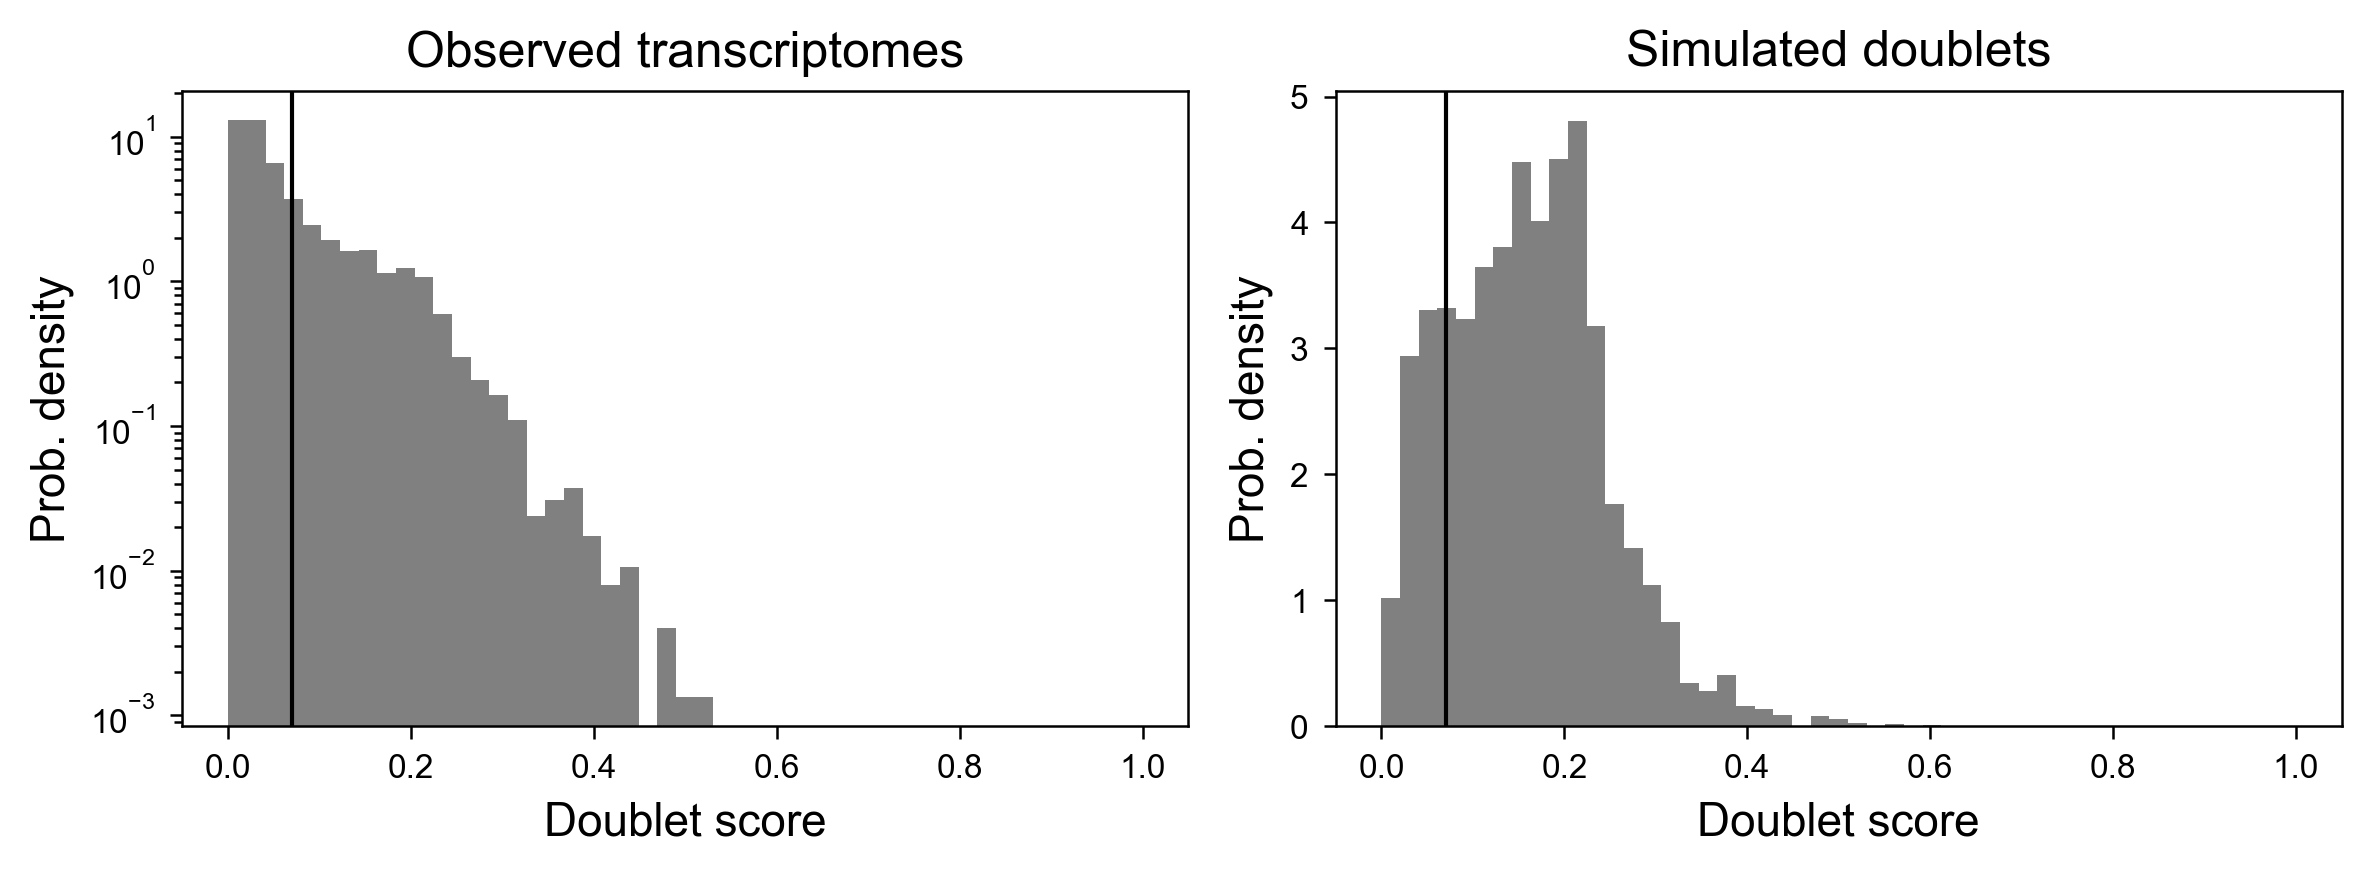

In [8]:
import scrublet as scr

scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.06)
doublet_scores, predicted_doublets = scrub.scrub_doublets(
    min_counts=2,
    min_cells=3,
    min_gene_variability_pctl=85,
    n_prin_comps=30
)

adata.obs['doublet_score'] = doublet_scores
adata.obs['predicted_doublet'] = predicted_doublets

scrub.plot_histogram()

n_doublets = adata.obs['predicted_doublet'].sum()
print(f"Detected {n_doublets} doublets ({100*n_doublets/adata.n_obs:.1f}%)")
adata = adata[~adata.obs['predicted_doublet'], :].copy()
print(f"Remaining cells: {adata.n_obs}")

## Quality Control

Scrublet called 29.5% of barcodes as doublets, which seems high. The auto-threshold
was 0.07 based on the bimodal score distribution. After removing those plus standard QC
filters (200-2500 genes, <5% mito), we go from 36,863 down to 8,885 cells. Most of that
drop comes from the max_genes=2500 cutoff.

In [ ]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=False)

mt_upper = adata.var_names.str.startswith("MT-").sum()
mt_lower = adata.var["mt"].sum()
print(f"MT- genes (uppercase): {mt_upper}")
print(f"mt- genes (lowercase): {mt_lower}")

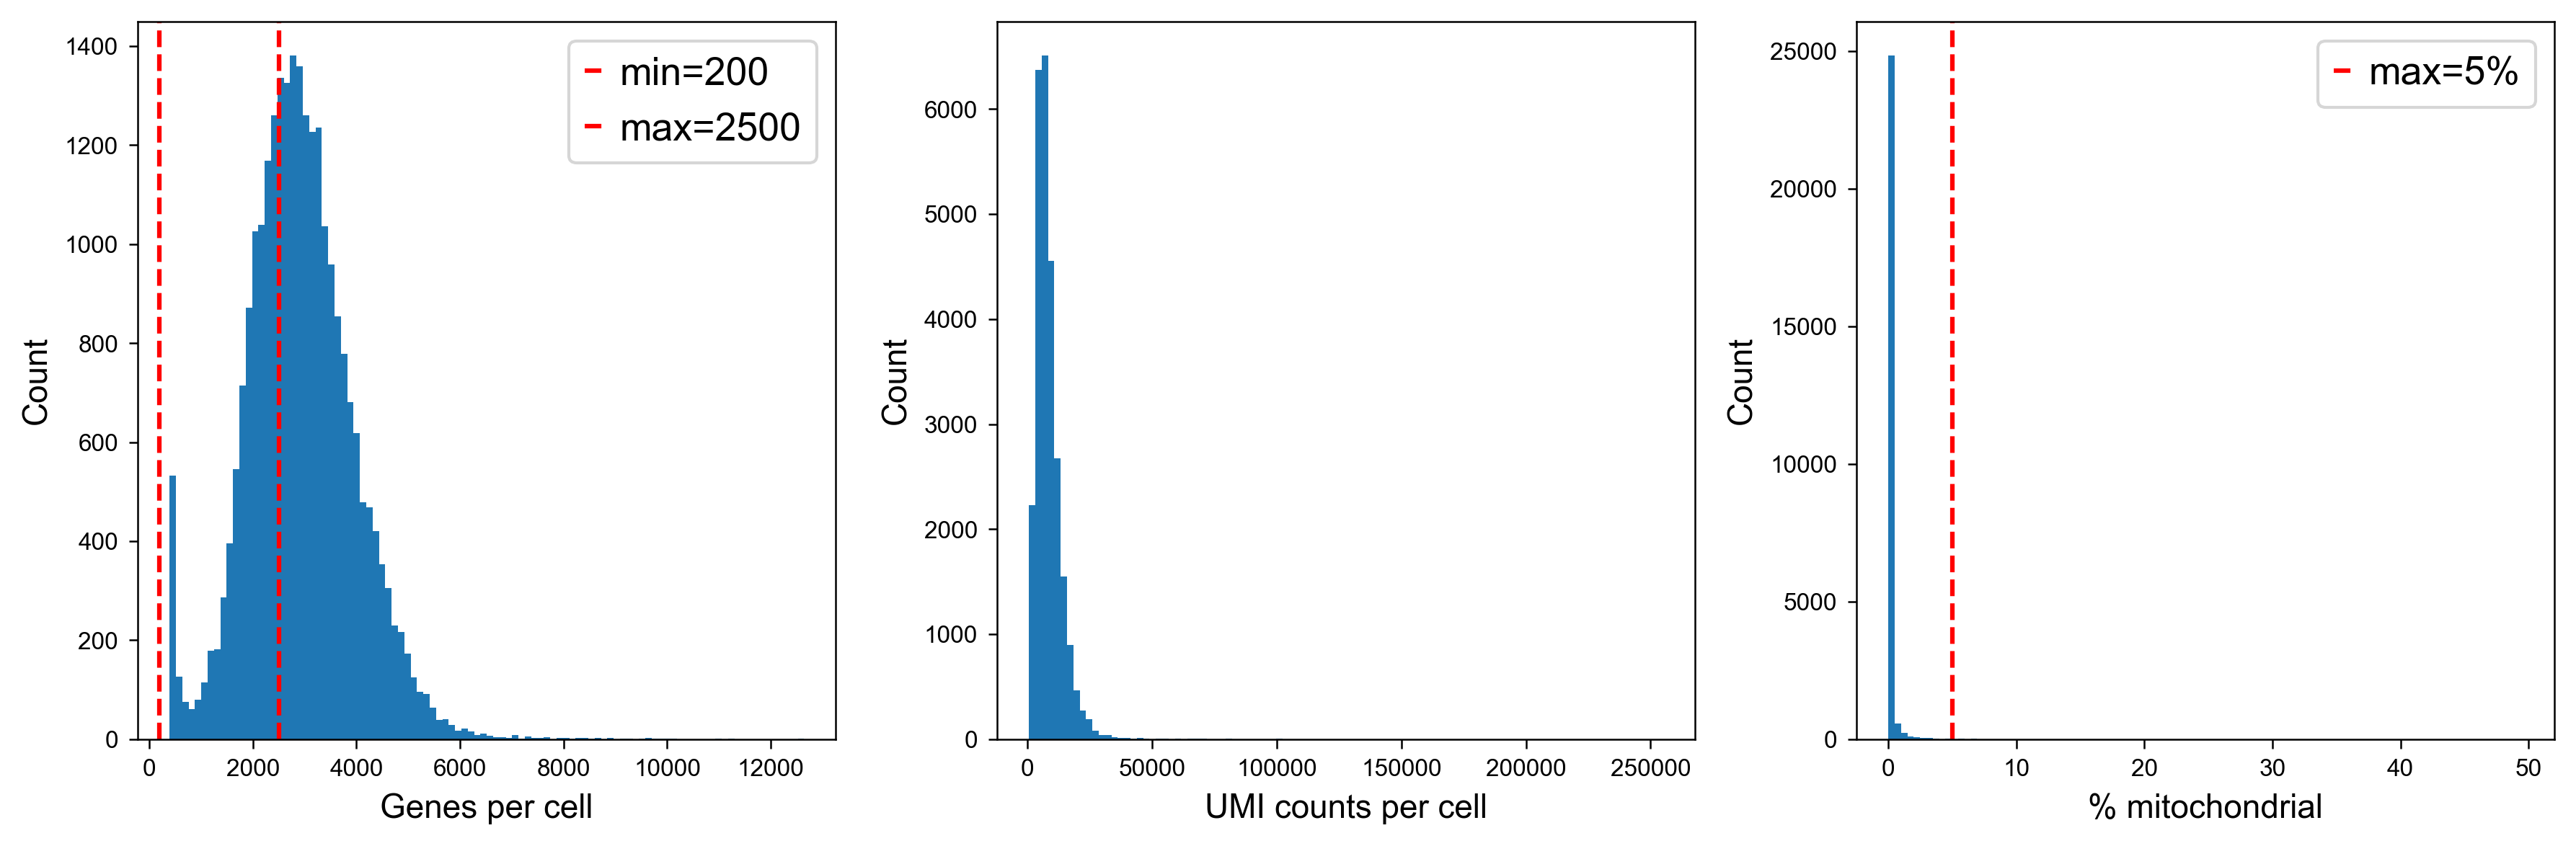

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.hist(adata.obs["n_genes_by_counts"], bins=100)
ax1.axvline(200, color="red", linestyle="--", label="min=200")
ax1.axvline(2500, color="red", linestyle="--", label="max=2500")
ax1.set_xlabel("Genes per cell")
ax1.set_ylabel("Count")
ax1.legend()

ax2.hist(adata.obs["total_counts"], bins=100)
ax2.set_xlabel("UMI counts per cell")
ax2.set_ylabel("Count")

ax3.hist(adata.obs["pct_counts_mt"], bins=100)
ax3.axvline(5, color="red", linestyle="--", label="max=5%")
ax3.set_xlabel("% mitochondrial")
ax3.set_ylabel("Count")
ax3.legend()

plt.tight_layout()
plt.show()

In [11]:
print(f"Before filtering: {adata.n_obs} cells")

sc.pp.filter_cells(adata, min_genes=200)
print(f"After min_genes=200: {adata.n_obs} cells")

adata = adata[adata.obs.n_genes_by_counts < 2500, :].copy()
print(f"After max_genes=2500: {adata.n_obs} cells")

adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
print(f"After pct_mt<5%: {adata.n_obs} cells")

sc.pp.filter_genes(adata, min_cells=3)
print(f"After min_cells=3: {adata.n_obs} cells, {adata.n_vars} genes")

Before filtering: 25979 cells
After min_genes=200: 25979 cells
After max_genes=2500: 8949 cells
After pct_mt<5%: 8885 cells
filtered out 10699 genes that are detected in less than 3 cells
After min_cells=3: 8885 cells, 21586 genes


## Normalization

Using Pearson residuals normalization, which fits a negative binomial model to the count
data and returns residuals. This handles the variance-mean relationship in UMI counts
better than simple log-normalization. Selecting 3,000 HVGs.

In [ ]:
adata.layers["counts"] = adata.X.copy()

sc.experimental.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    flavor="pearson_residuals",
    layer="counts"
)
sc.experimental.pp.normalize_pearson_residuals(adata)

In [13]:
print(f"Highly variable genes: {adata.var.highly_variable.sum()}")

Highly variable genes: 3000


## Dimensionality Reduction

50 PCs computed, using the top 30 for the neighbor graph. Elbow plot below to check
that 30 is a reasonable cutoff.

computing PCA
    with n_comps=50


/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


    finished (0:00:01)


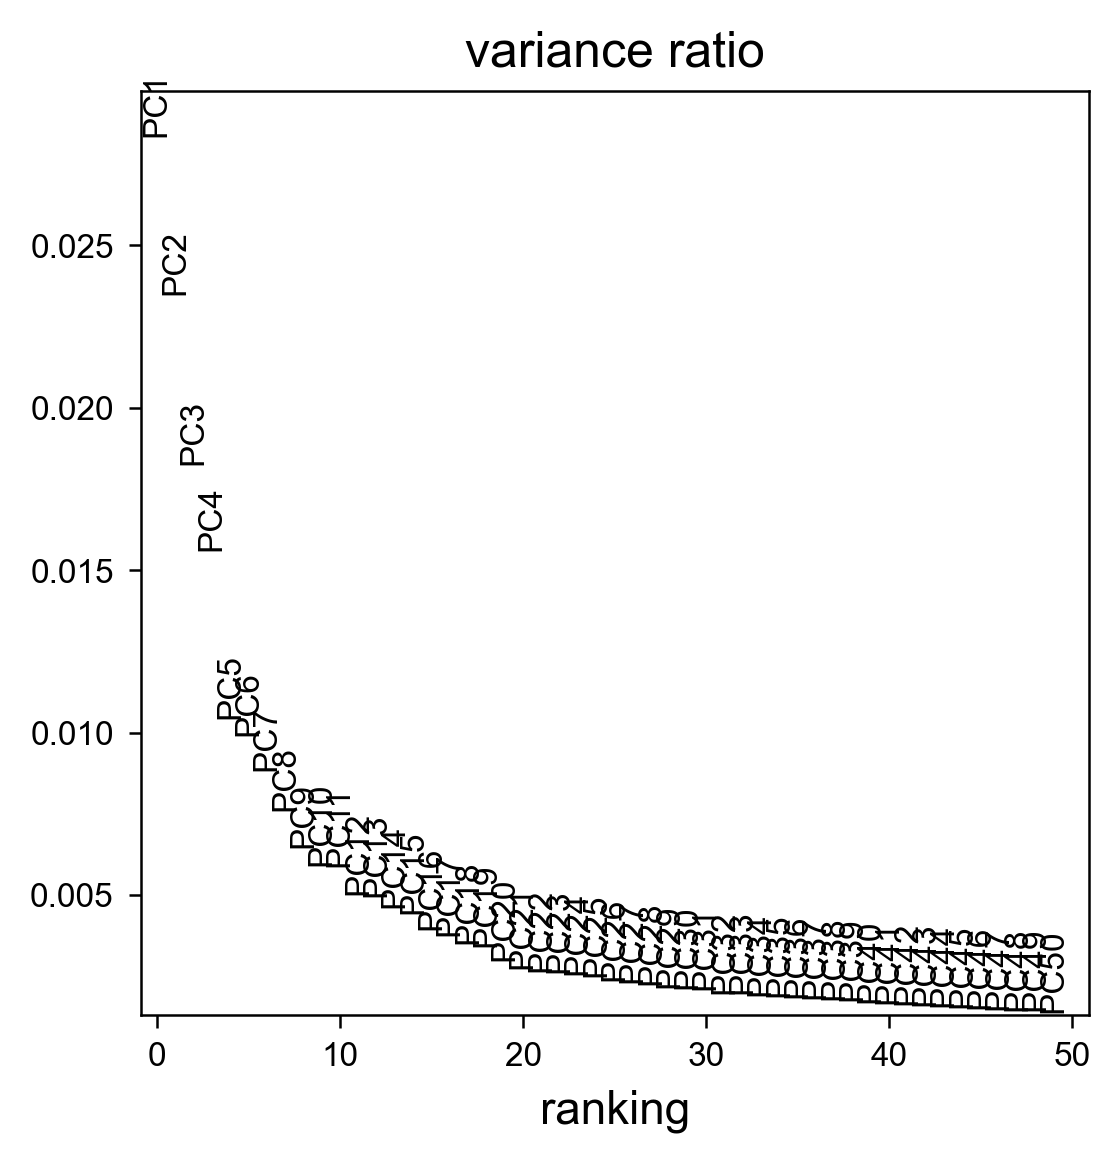

In [14]:
sc.tl.pca(adata, n_comps=50, use_highly_variable=True, random_state=SEED)
sc.pl.pca_variance_ratio(adata, n_pcs=50)

In [15]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30, random_state=SEED)
sc.tl.umap(adata, random_state=SEED)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:11)
computing UMAP
    finished (0:00:18)


## Clustering

Tested Leiden at a range of resolutions. Resolution 1.6 gives 28 clusters, which
captures the diversity in the data without over-splitting.

In [16]:
for res in [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]:
    sc.tl.leiden(
        adata,
        resolution=res,
        random_state=SEED,
        flavor="igraph",
        n_iterations=2,
        key_added=f"leiden_{res}"
    )
    n_clusters = adata.obs[f"leiden_{res}"].nunique()
    print(f"Resolution {res}: {n_clusters} clusters")

running Leiden clustering
    finished (0:00:00)
Resolution 0.8: 18 clusters
running Leiden clustering
    finished (0:00:00)
Resolution 1.0: 22 clusters
running Leiden clustering
    finished (0:00:00)
Resolution 1.2: 24 clusters
running Leiden clustering
    finished (0:00:00)
Resolution 1.4: 26 clusters
running Leiden clustering
    finished (0:00:00)
Resolution 1.6: 28 clusters
running Leiden clustering
    finished (0:00:00)
Resolution 1.8: 29 clusters
running Leiden clustering
    finished (0:00:00)
Resolution 2.0: 33 clusters


In [ ]:
best_res = 1.6
adata.obs["leiden"] = adata.obs[f"leiden_{best_res}"]
print(f"Selected resolution {best_res}: {adata.obs['leiden'].nunique()} clusters")

## Neuronal Marker Visualization

Looking at Slc17a7 (vGlut1, excitatory) and Gad1 (GABAergic, inhibitory) to sort out
which clusters are which. Also checking interneuron subtype markers (Pvalb, Sst, Vip, etc.)
to see how diverse the inhibitory population is.

In [19]:
neuronal_markers = [
    "Slc17a6",  # vGlut2 (excitatory)
    "Slc17a7",  # vGlut1 (excitatory)
    "Gad1",     # GABAergic (inhibitory)
    "Calb1",    # Calbindin (interneuron)
    "Calb2",    # Calretinin (interneuron)
    "Cck",      # Cholecystokinin (interneuron)
    "Vip",      # VIP (interneuron)
    "Npy",      # Neuropeptide Y (interneuron)
    "Pvalb",    # Parvalbumin (interneuron)
    "Sst",      # Somatostatin (interneuron)
]

markers_present = [m for m in neuronal_markers if m in adata.var_names]
markers_missing = [m for m in neuronal_markers if m not in adata.var_names]
if markers_missing:
    print(f"Missing markers: {markers_missing}")

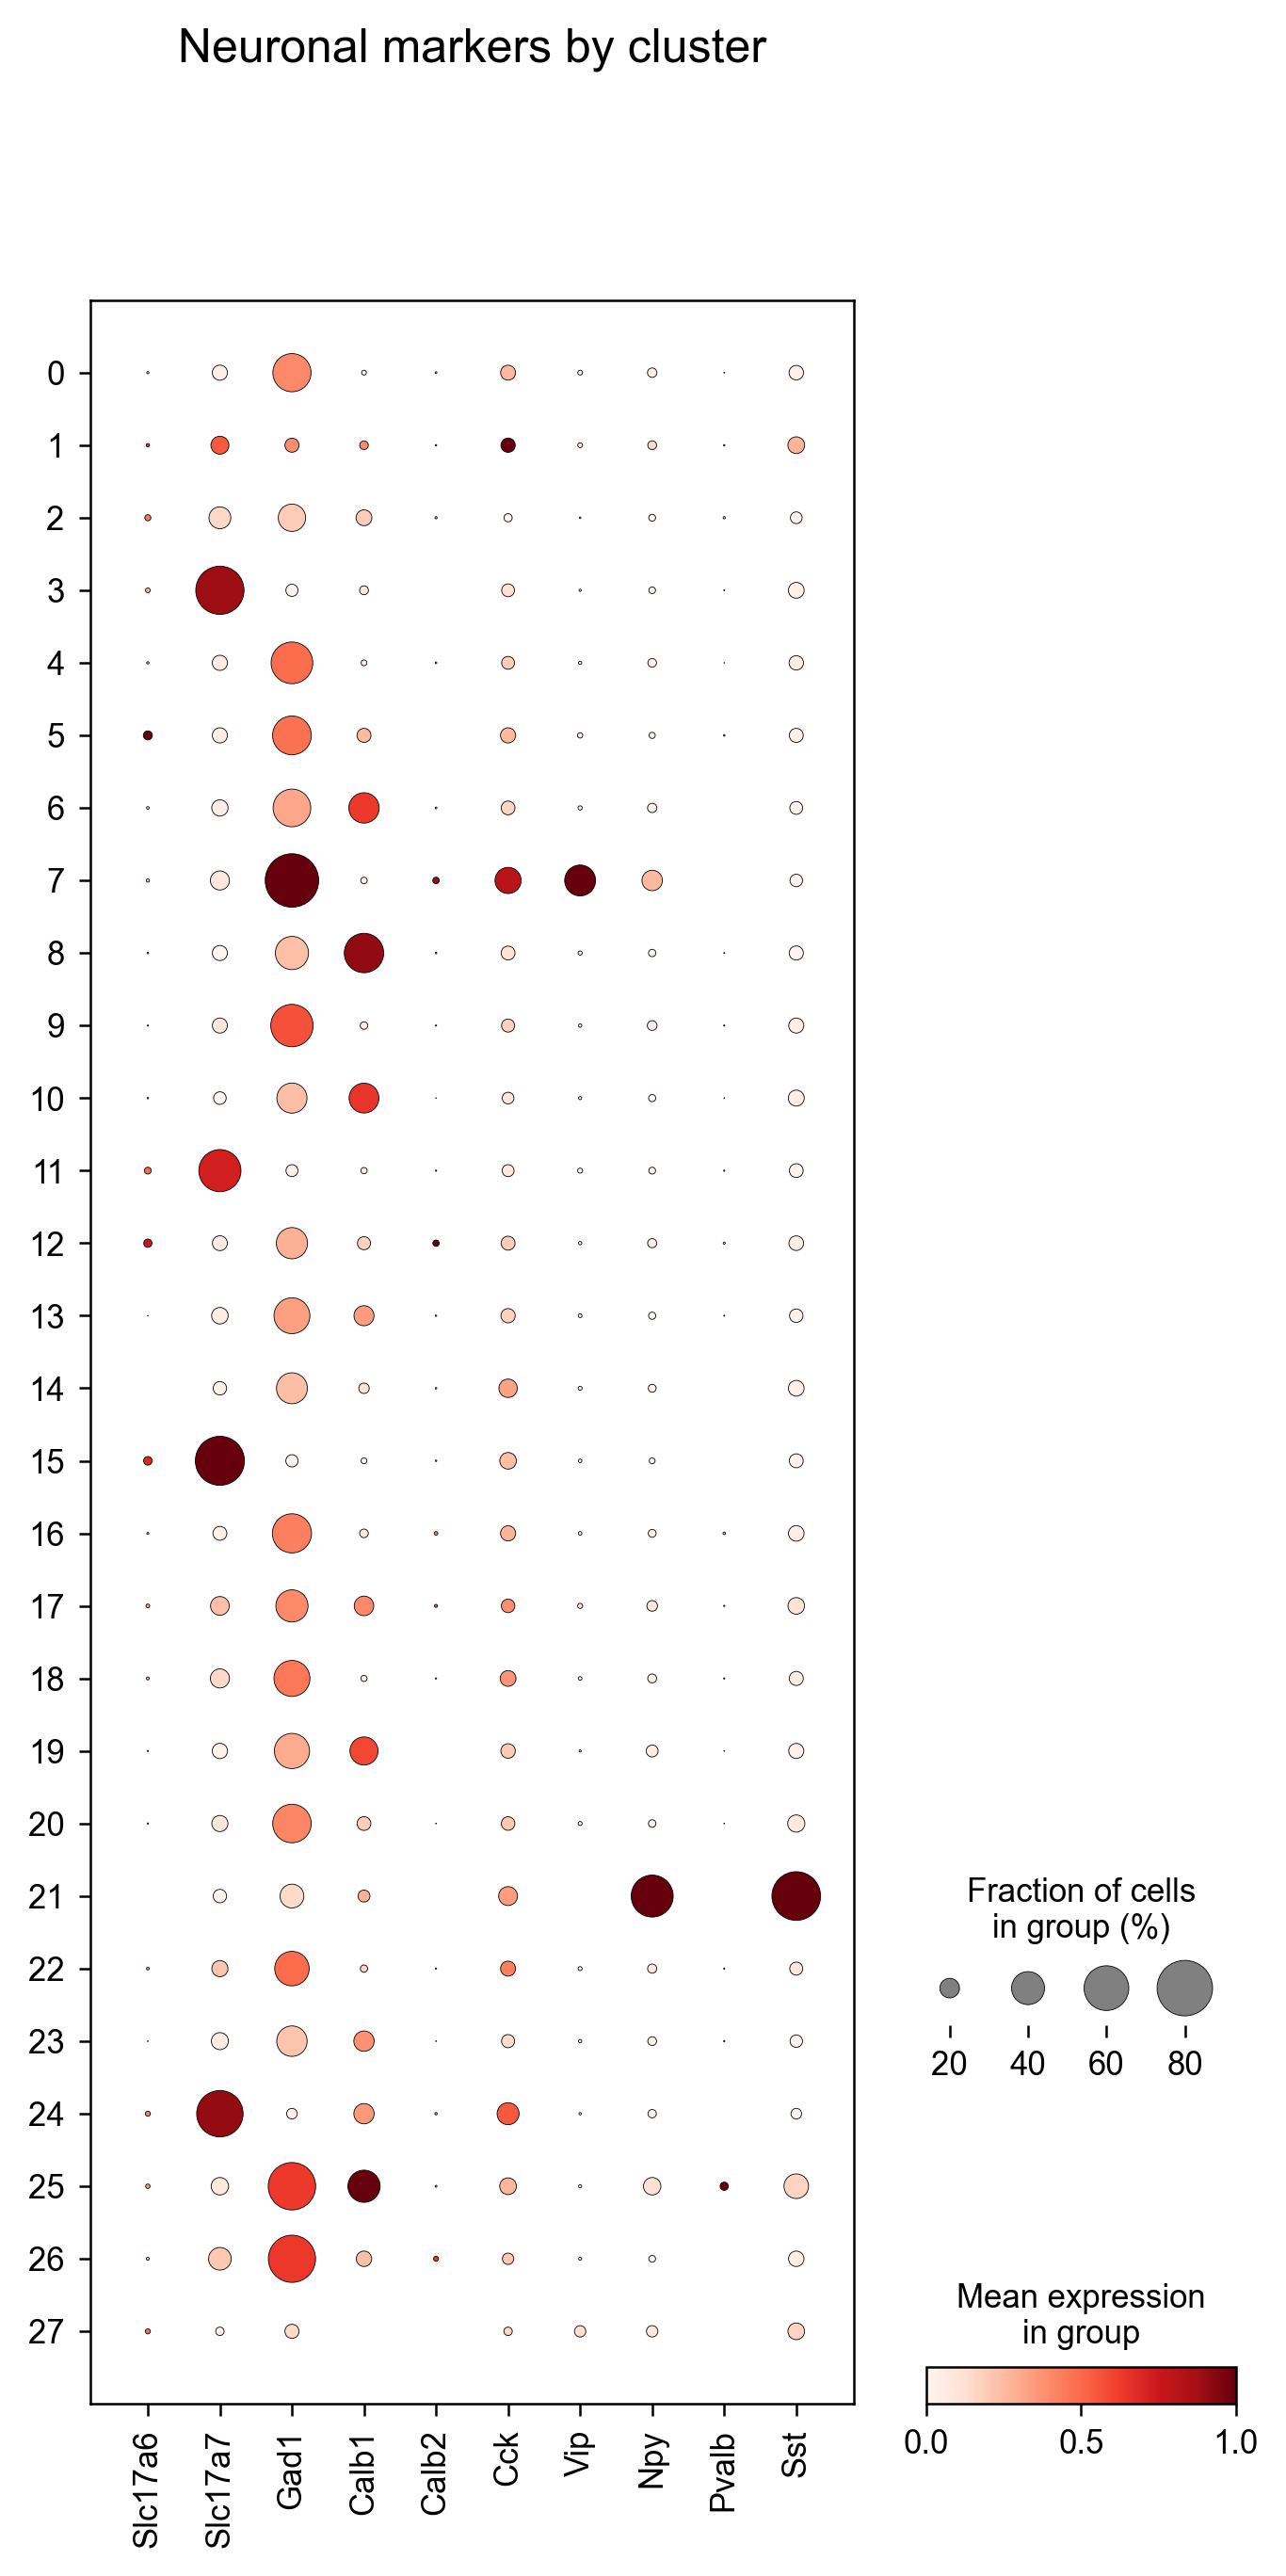

In [20]:
sc.pl.dotplot(
    adata,
    markers_present,
    groupby="leiden",
    standard_scale="var",
    title="Neuronal markers by cluster"
)

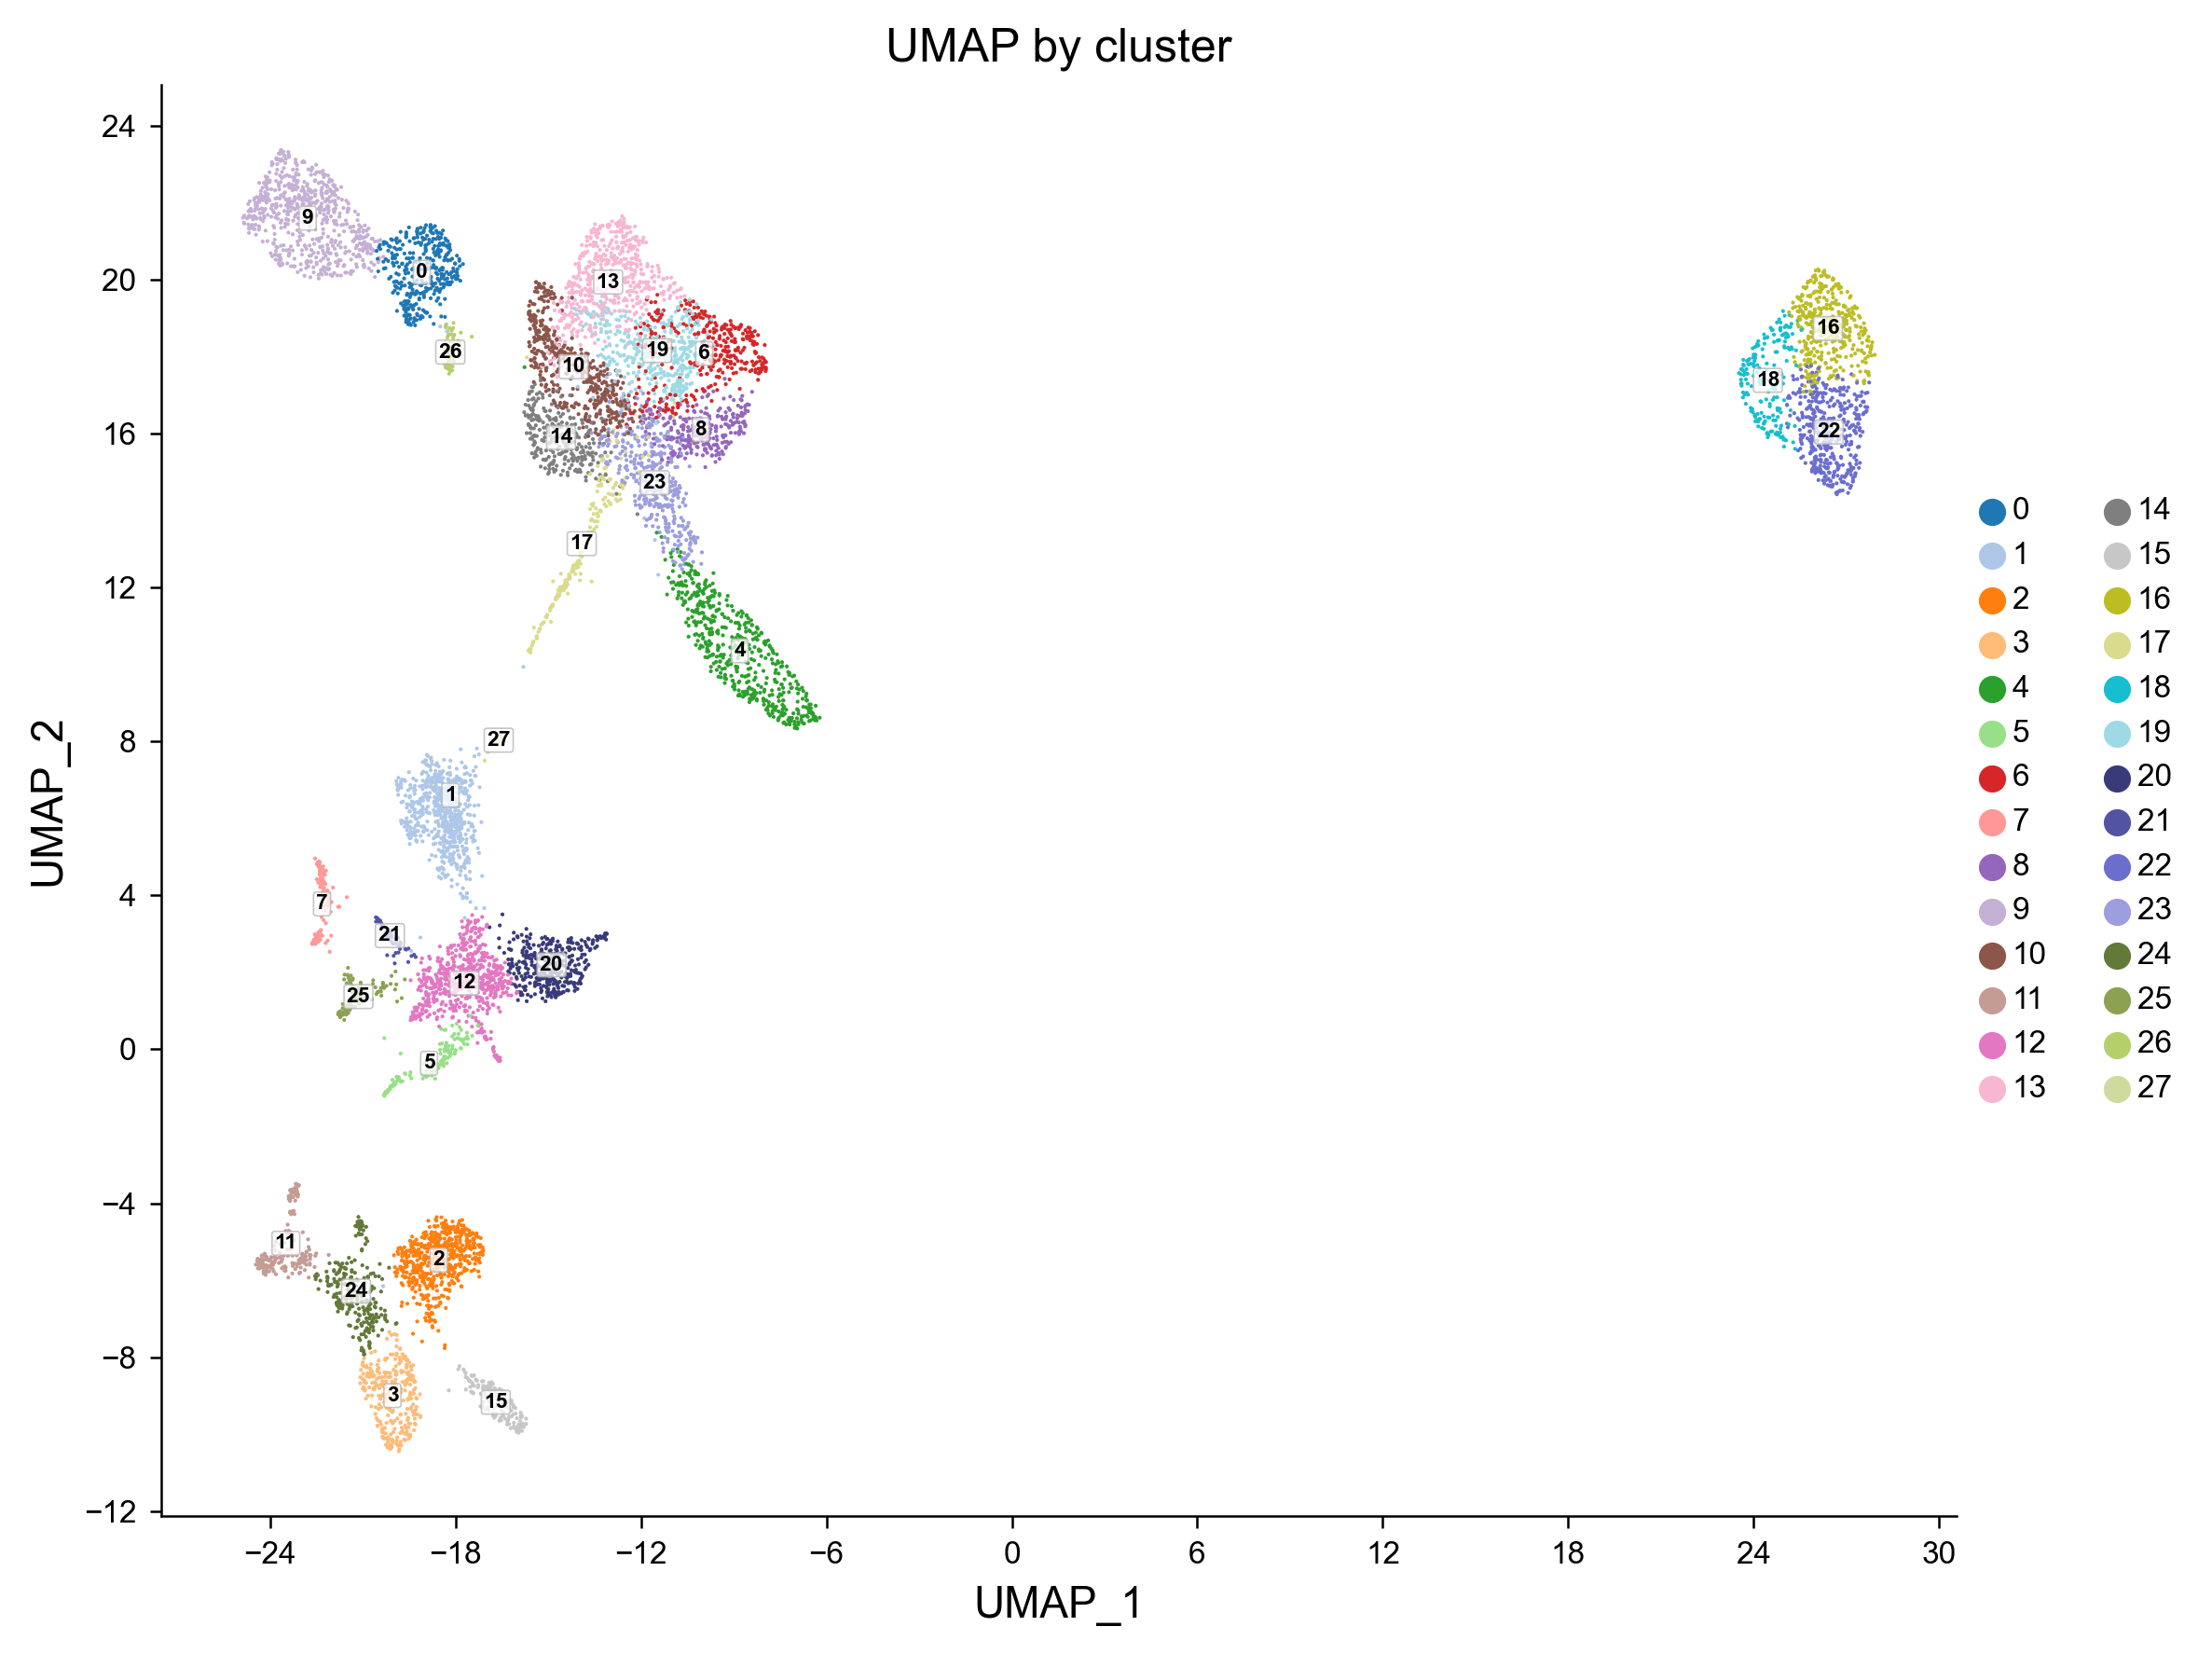

In [21]:
n_clusters = adata.obs["leiden"].nunique()
palette = [plt.cm.tab20(i / 20) for i in range(20)] + [plt.cm.tab20b(i / 20) for i in range(n_clusters - 20)]

fig, ax = plt.subplots(figsize=(8, 6))
sc.pl.umap(
    adata,
    color="leiden",
    legend_loc="right margin",
    legend_fontsize=8,
    title="UMAP by cluster",
    size=4,
    palette=palette,
    frameon=True,
    ax=ax,
    show=False
)

for cluster in adata.obs["leiden"].cat.categories:
    mask = adata.obs["leiden"] == cluster
    coords = adata.obsm["X_umap"][mask]
    cx, cy = coords[:, 0].mean(), coords[:, 1].mean()
    ax.text(cx, cy, cluster, fontsize=5.5, fontweight="bold", ha="center", va="center",
            bbox=dict(boxstyle="round,pad=0.12", fc="white", ec="0.7", lw=0.4, alpha=0.75))

ax.set_xlabel("UMAP_1")
ax.set_ylabel("UMAP_2")
ax.tick_params(labelbottom=True, labelleft=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "UMAP_Scanpy.png", dpi=200, bbox_inches="tight")
plt.show()

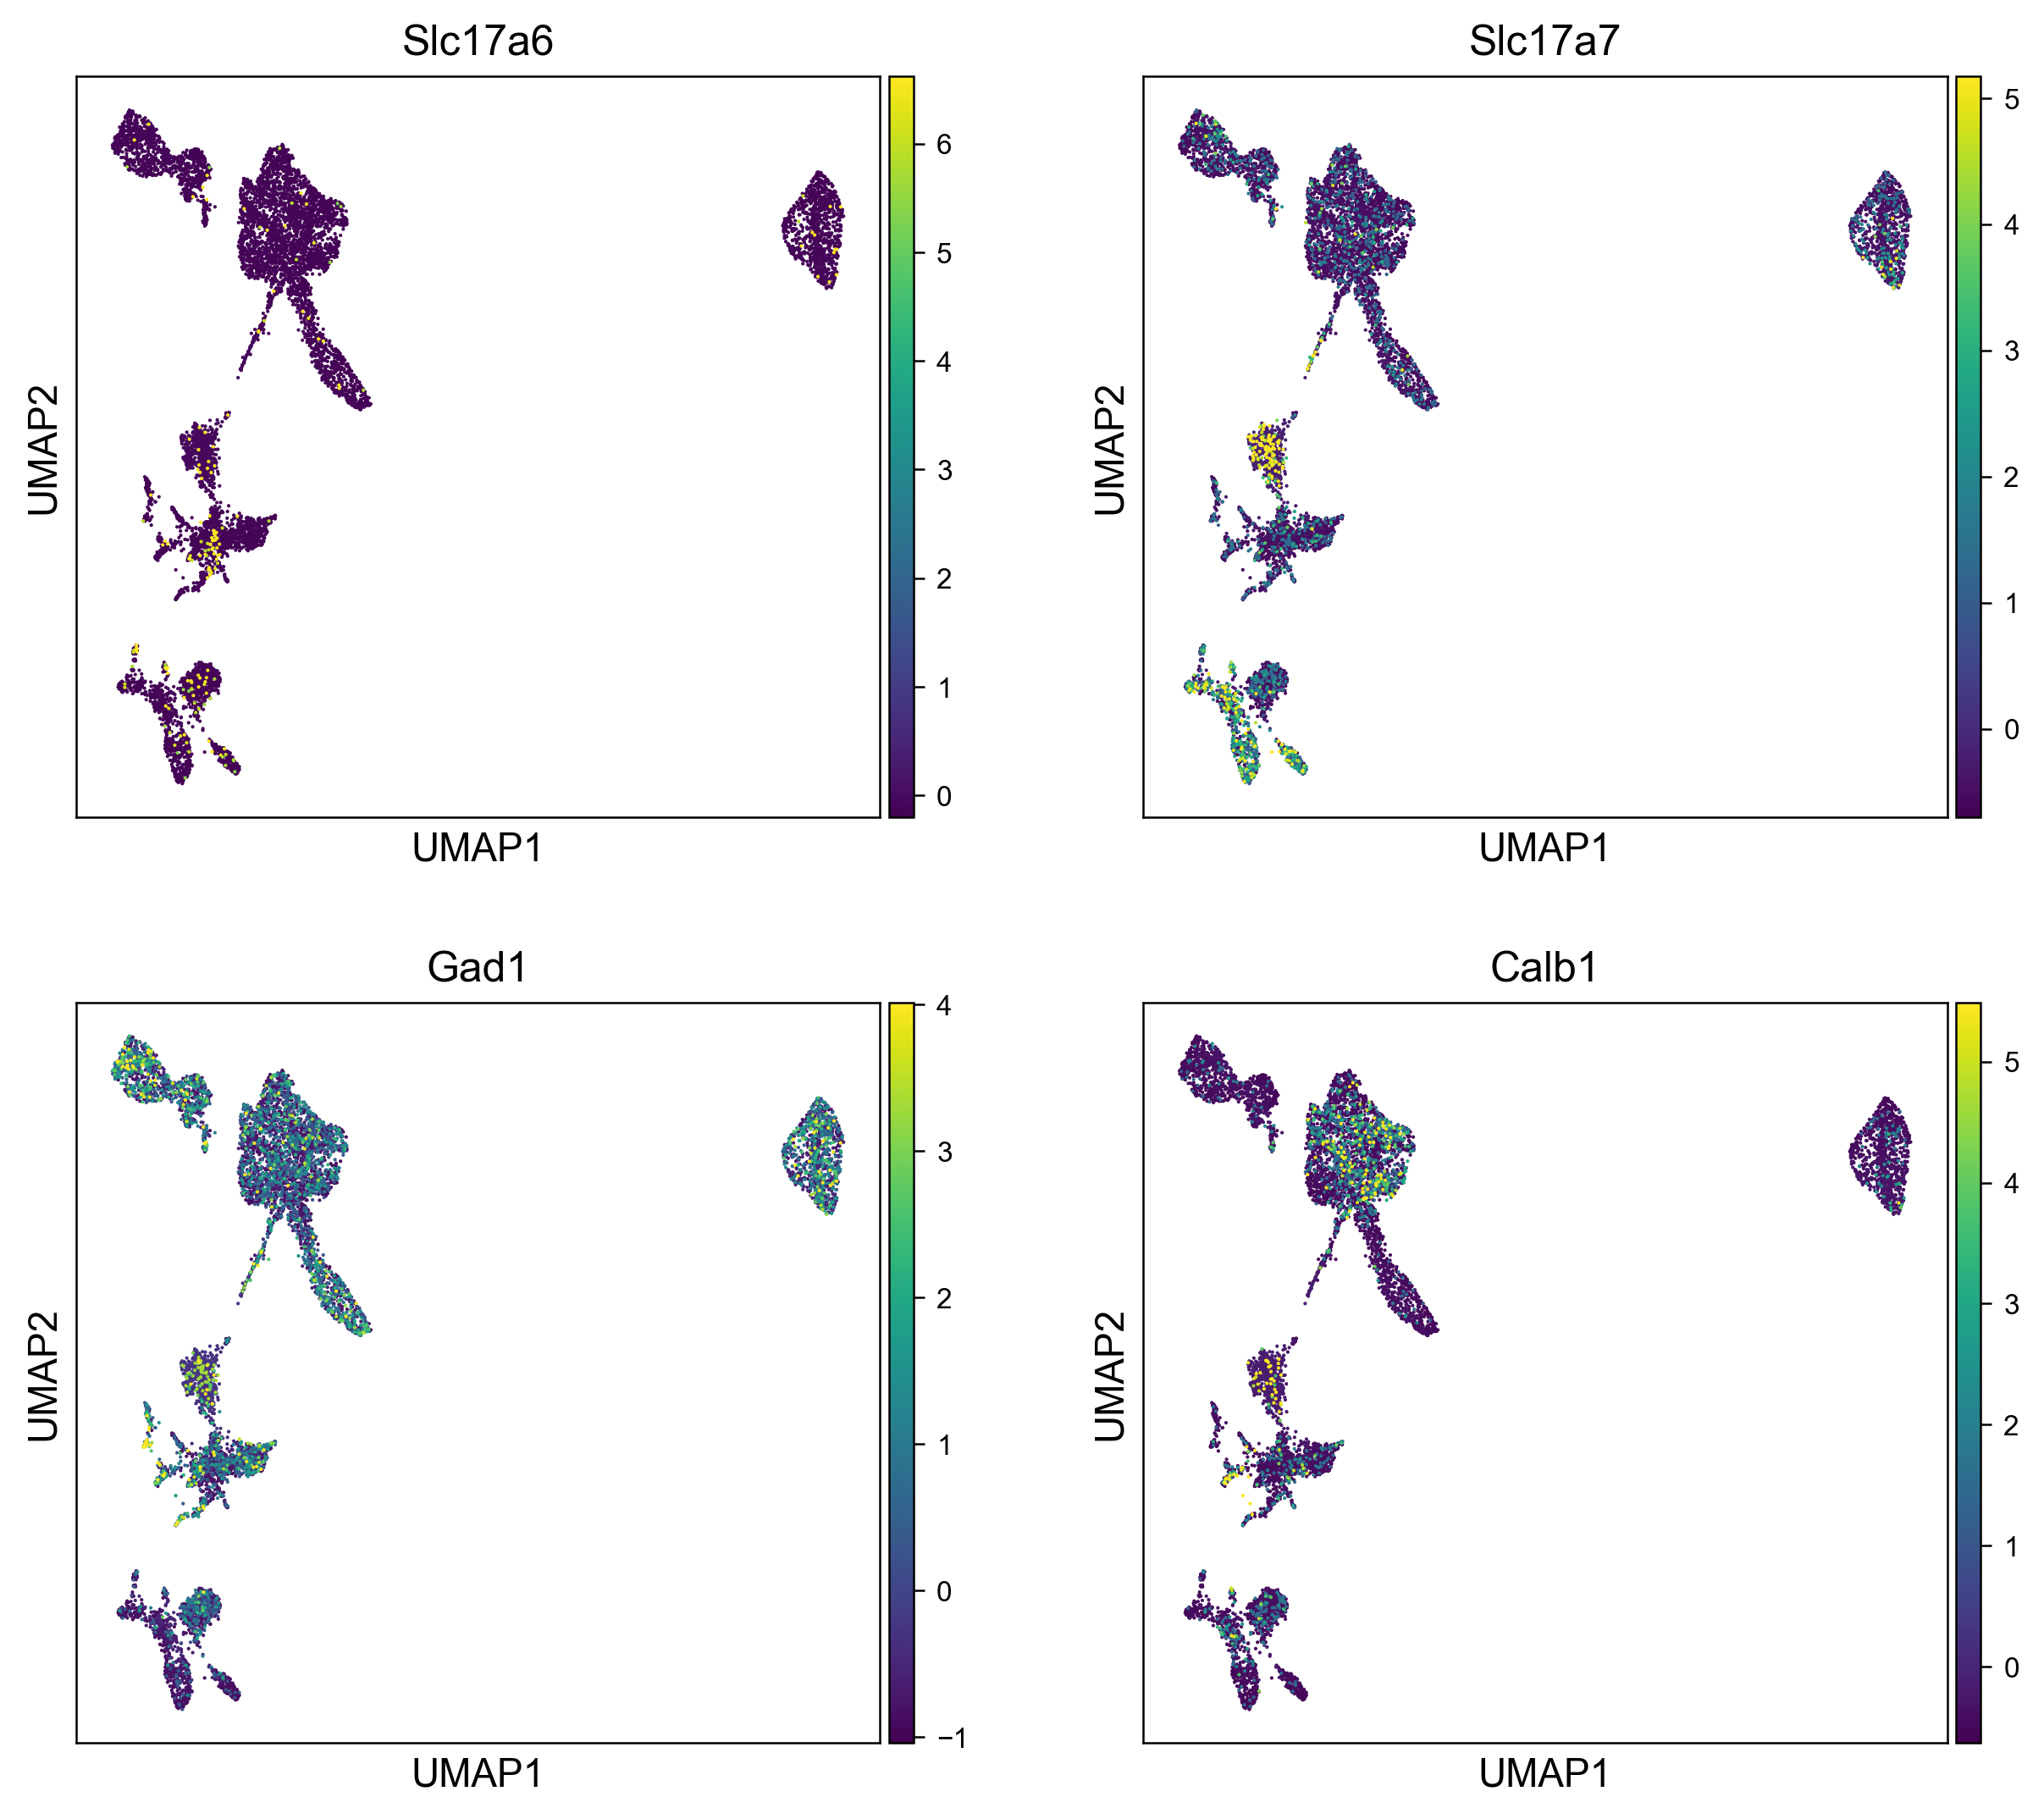

In [22]:
sc.pl.umap(adata, color=markers_present[:4], ncols=2, vmax="p99", size=4)

## Marker Gene Discovery

Wilcoxon rank-sum test across all clusters, keeping only positive markers (genes enriched
in a given cluster vs everything else).

In [23]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon", key_added="wilcoxon")

ranking genes


/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py

    finished (0:00:15)


/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/tisyasharma/opt/anaconda3/envs/cap_stable/lib/python3.12/site-packages/scanp

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


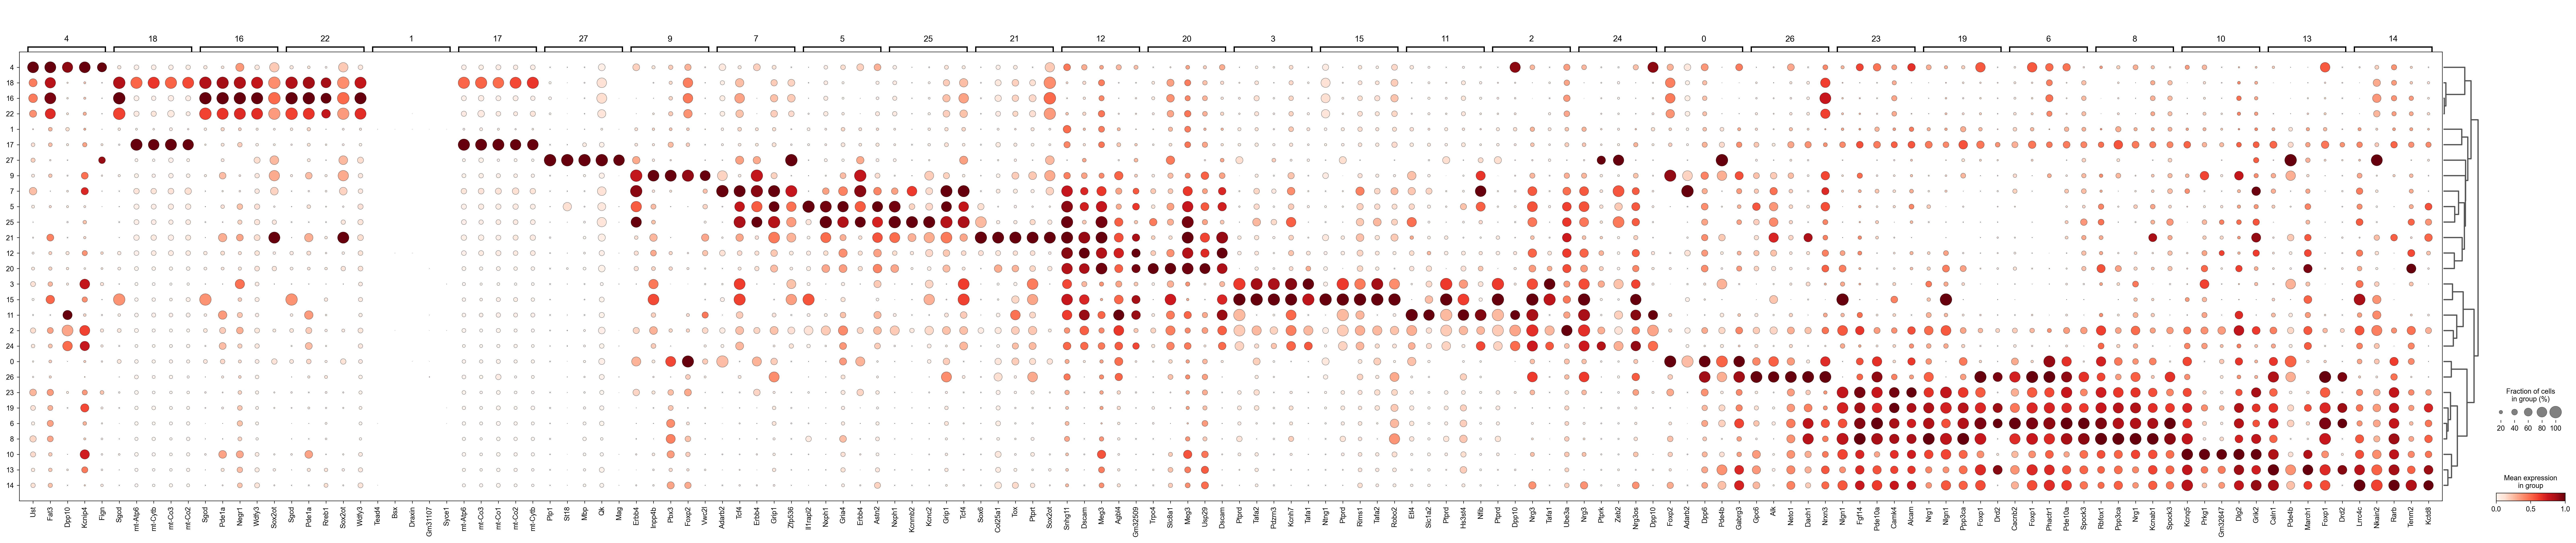

In [24]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="leiden",
    key="wilcoxon",
    n_genes=5,
    standard_scale="var"
)

In [25]:
markers_df = sc.get.rank_genes_groups_df(adata, group=None, key="wilcoxon")
markers_df = markers_df[markers_df["logfoldchanges"] > 0]  # positive only
print(f"Total positive markers: {len(markers_df)}")
markers_df.head(20)

Total positive markers: 185332


group     names    scores  logfoldchanges         pvals     pvals_adj
104     0    Thsd7b  8.322573        9.653131  8.607424e-17  7.402384e-15
189     0      Rtn1  5.471292        4.514846  4.467661e-08  1.339430e-06
210     0      Tac1  5.098849        2.523936  3.417246e-07  7.642018e-06
213     0      Pcp4  5.043061        5.946559  4.581420e-07  9.639371e-06
218     0    Atp2b4  4.918512        5.657213  8.720467e-07  1.567360e-05
235     0     Car11  4.518327        3.948301  6.233015e-06  3.366633e-05
242     0      Syt6  4.361704        4.529847  1.290535e-05  3.366633e-05
243     0  Tmem191c  4.360131        5.243926  1.299848e-05  3.366633e-05
246     0       Ckb  4.284352        2.378441  1.832726e-05  3.919059e-05
247     0      Nrgn  4.274189        7.862110  1.918345e-05  4.019939e-05
260     0     Ptpro  3.953317        7.582898  7.707513e-05  1.184328e-04
264     0   Rap1gap  3.889946        6.427433  1.002664e-04  1.495233e-04
268     0     Fgf13  3.807193        6.739028  1.405531e-04  2.027519e-04
269     0      Hap1  3.806920        4.048839  1.407081e-04  2.029619e-04
271     0    Brinp2  3.781245        5.120518  1.560462e-04  2.230885e-04
278     0      Aff2  3.664320        3.885590  2.479966e-04  3.412106e-04
282     0    Malat1  3.635393        1.962013  2.775572e-04  3.784328e-04
289     0       Tef  3.539886        6.213538  4.003004e-04  5.318121e-04
308     0    Sox1ot  3.307599        3.032912  9.409937e-04  1.189801e-03
316     0      Ddx5  3.232251        1.846681  1.228193e-03  1.530703e-03

In [26]:
top5_per_cluster = markers_df.groupby("group", observed=True).head(5)
top5_per_cluster.to_csv(OUTPUT_DIR / "top5_markers_per_cluster_TS.csv", index=False)
print(f"Saved top 5 markers per cluster to {OUTPUT_DIR / 'top5_markers_per_cluster_TS.csv'}")

Saved top 5 markers per cluster to /Users/tisyasharma/Documents/Courses/AON_SnRNASeq_TS/output/top5_markers_per_cluster_TS.csv


## Excitatory vs Inhibitory Classification

Comparing mean raw Slc17a7 vs Gad1 per cluster. Results in 5 excitatory and 23 inhibitory, which makes sense for AON (mostly inhibitory interneurons).

In [27]:
cluster_expr = pd.DataFrame(index=adata.obs["leiden"].cat.categories)

for gene in ["Slc17a7", "Gad1"]:
    if gene in adata.var_names:
        gene_idx = adata.var_names.get_loc(gene)
        expr = adata.layers["counts"][:, gene_idx].toarray().flatten()
        expr_series = pd.Series(expr, index=adata.obs.index)
        cluster_expr[gene] = expr_series.groupby(adata.obs["leiden"], observed=True).mean()

cluster_expr["ratio"] = cluster_expr["Slc17a7"] / (cluster_expr["Gad1"] + 0.01)
cluster_expr["cell_class"] = np.where(cluster_expr["ratio"] > 1, "Excitatory", "Inhibitory")
cluster_expr

Slc17a7      Gad1     ratio  cell_class
0   0.147222  0.736111  0.197319  Inhibitory
1   0.195620  0.144526  1.265942  Excitatory
2   0.263736  0.371795  0.690780  Inhibitory
3   1.058394  0.116788  8.347727  Excitatory
4   0.152985  0.826493  0.182889  Inhibitory
5   0.156028  0.808511  0.190625  Inhibitory
6   0.176136  0.659091  0.263247  Inhibitory
7   0.201835  1.724771  0.116347  Inhibitory
8   0.158273  0.575540  0.270303  Inhibitory
9   0.162939  0.947284  0.170210  Inhibitory
10  0.123913  0.489130  0.248258  Inhibitory
11  0.864130  0.119565  6.669463  Excitatory
12  0.159247  0.501712  0.311203  Inhibitory
13  0.175403  0.635081  0.271909  Inhibitory
14  0.134948  0.477509  0.276812  Inhibitory
15  1.206667  0.120000  9.282052  Excitatory
16  0.136598  0.747423  0.180346  Inhibitory
17  0.204420  0.563536  0.356420  Inhibitory
18  0.197861  0.689840  0.282723  Inhibitory
19  0.151282  0.602564  0.246965  Inhibitory
20  0.172872  0.726064  0.234861  Inhibitory
21  0.120690  0.293103  0.398180  Inhibitory
22  0.187952  0.563855  0.327525  Inhibitory
23  0.171662  0.444142  0.377992  Inhibitory
24  0.991968  0.104418  8.669708  Excitatory
25  0.180180  1.117117  0.159859  Inhibitory
26  0.274194  1.064516  0.255179  Inhibitory
27  0.064516  0.161290  0.376648  Inhibitory

In [28]:
excitatory_clusters = cluster_expr[cluster_expr["cell_class"] == "Excitatory"].index.tolist()
inhibitory_clusters = cluster_expr[cluster_expr["cell_class"] == "Inhibitory"].index.tolist()

print(f"Excitatory clusters ({len(excitatory_clusters)}): {excitatory_clusters}")
print(f"Inhibitory clusters ({len(inhibitory_clusters)}): {inhibitory_clusters}")

Excitatory clusters (5): ['1', '3', '11', '15', '24']
Inhibitory clusters (23): ['0', '2', '4', '5', '6', '7', '8', '9', '10', '12', '13', '14', '16', '17', '18', '19', '20', '21', '22', '23', '25', '26', '27']


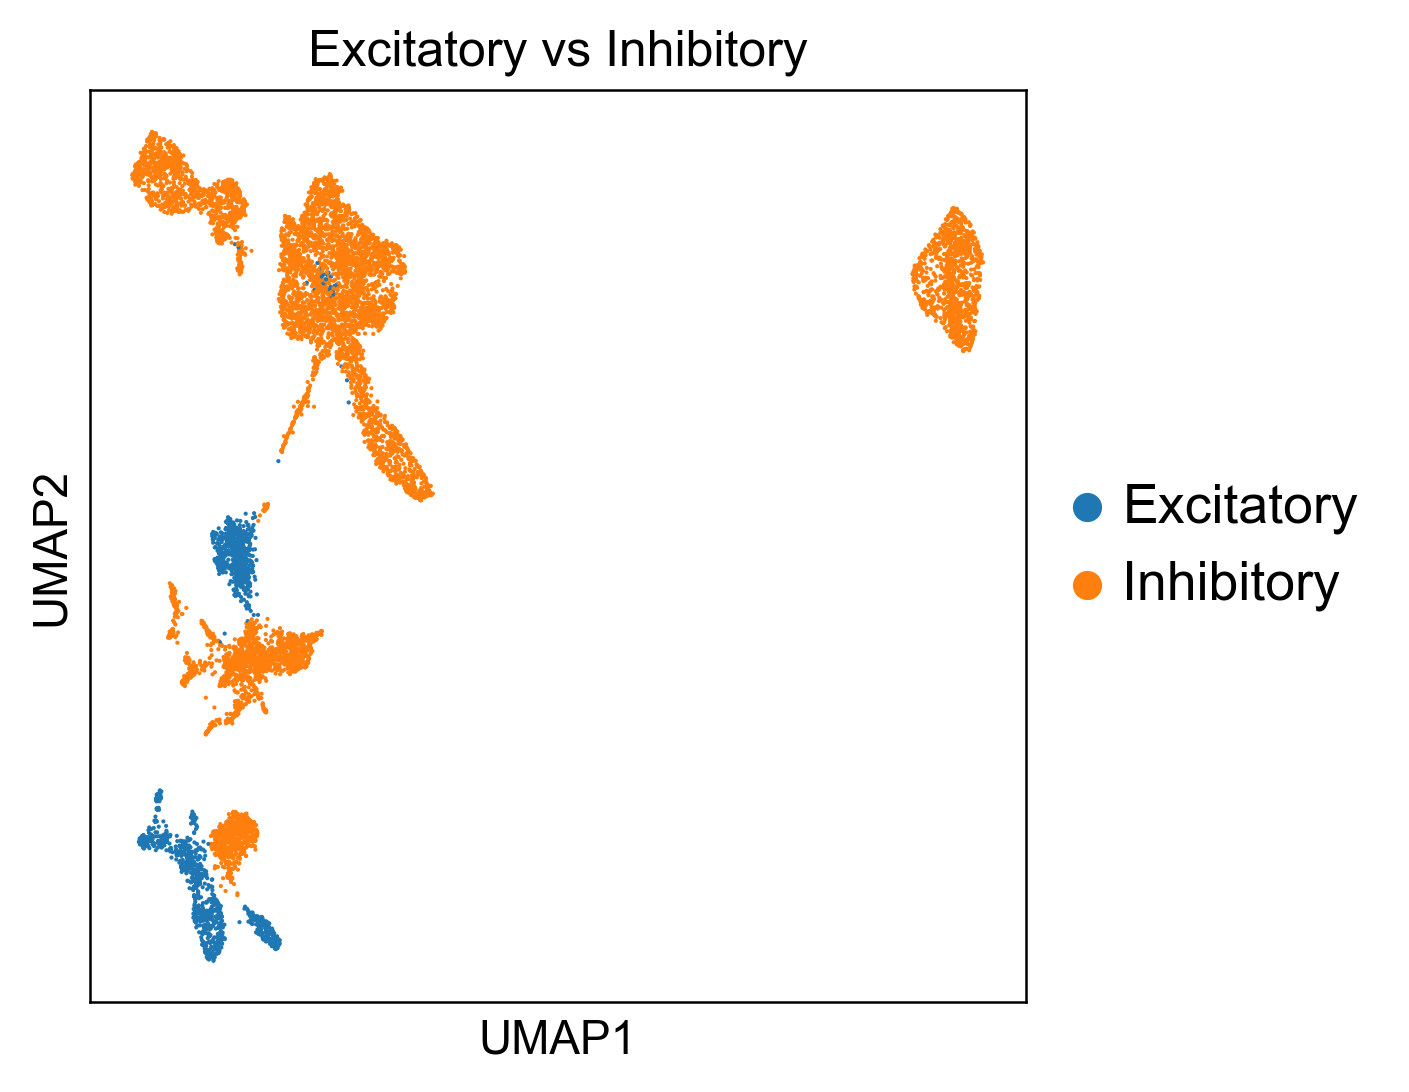

In [29]:
adata.obs["cell_class"] = adata.obs["leiden"].map(cluster_expr["cell_class"].to_dict())
sc.pl.umap(adata, color="cell_class", title="Excitatory vs Inhibitory", size=4)

## Candidate Gene Analysis

Checking the candidate markers (Robo2, Abi3bp, Gabrg1, Adcyap1, Chrm3, Rprm,
Thrb, Cntn5) to see how they look across our clusters. These came from the Allen 10x DE
analysis.

In [30]:
candidates_df = pd.read_csv(AON_DIR / "Candidate_Genes.csv")
candidate_genes = candidates_df["GeneName"].tolist()

genes_found = [g for g in candidate_genes if g in adata.var_names]
genes_missing = [g for g in candidate_genes if g not in adata.var_names]

print(f"Candidate genes found: {len(genes_found)}/{len(candidate_genes)}")
if genes_missing:
    print(f"Missing: {genes_missing[:10]}{'...' if len(genes_missing) > 10 else ''}")

Candidate genes found: 118/118


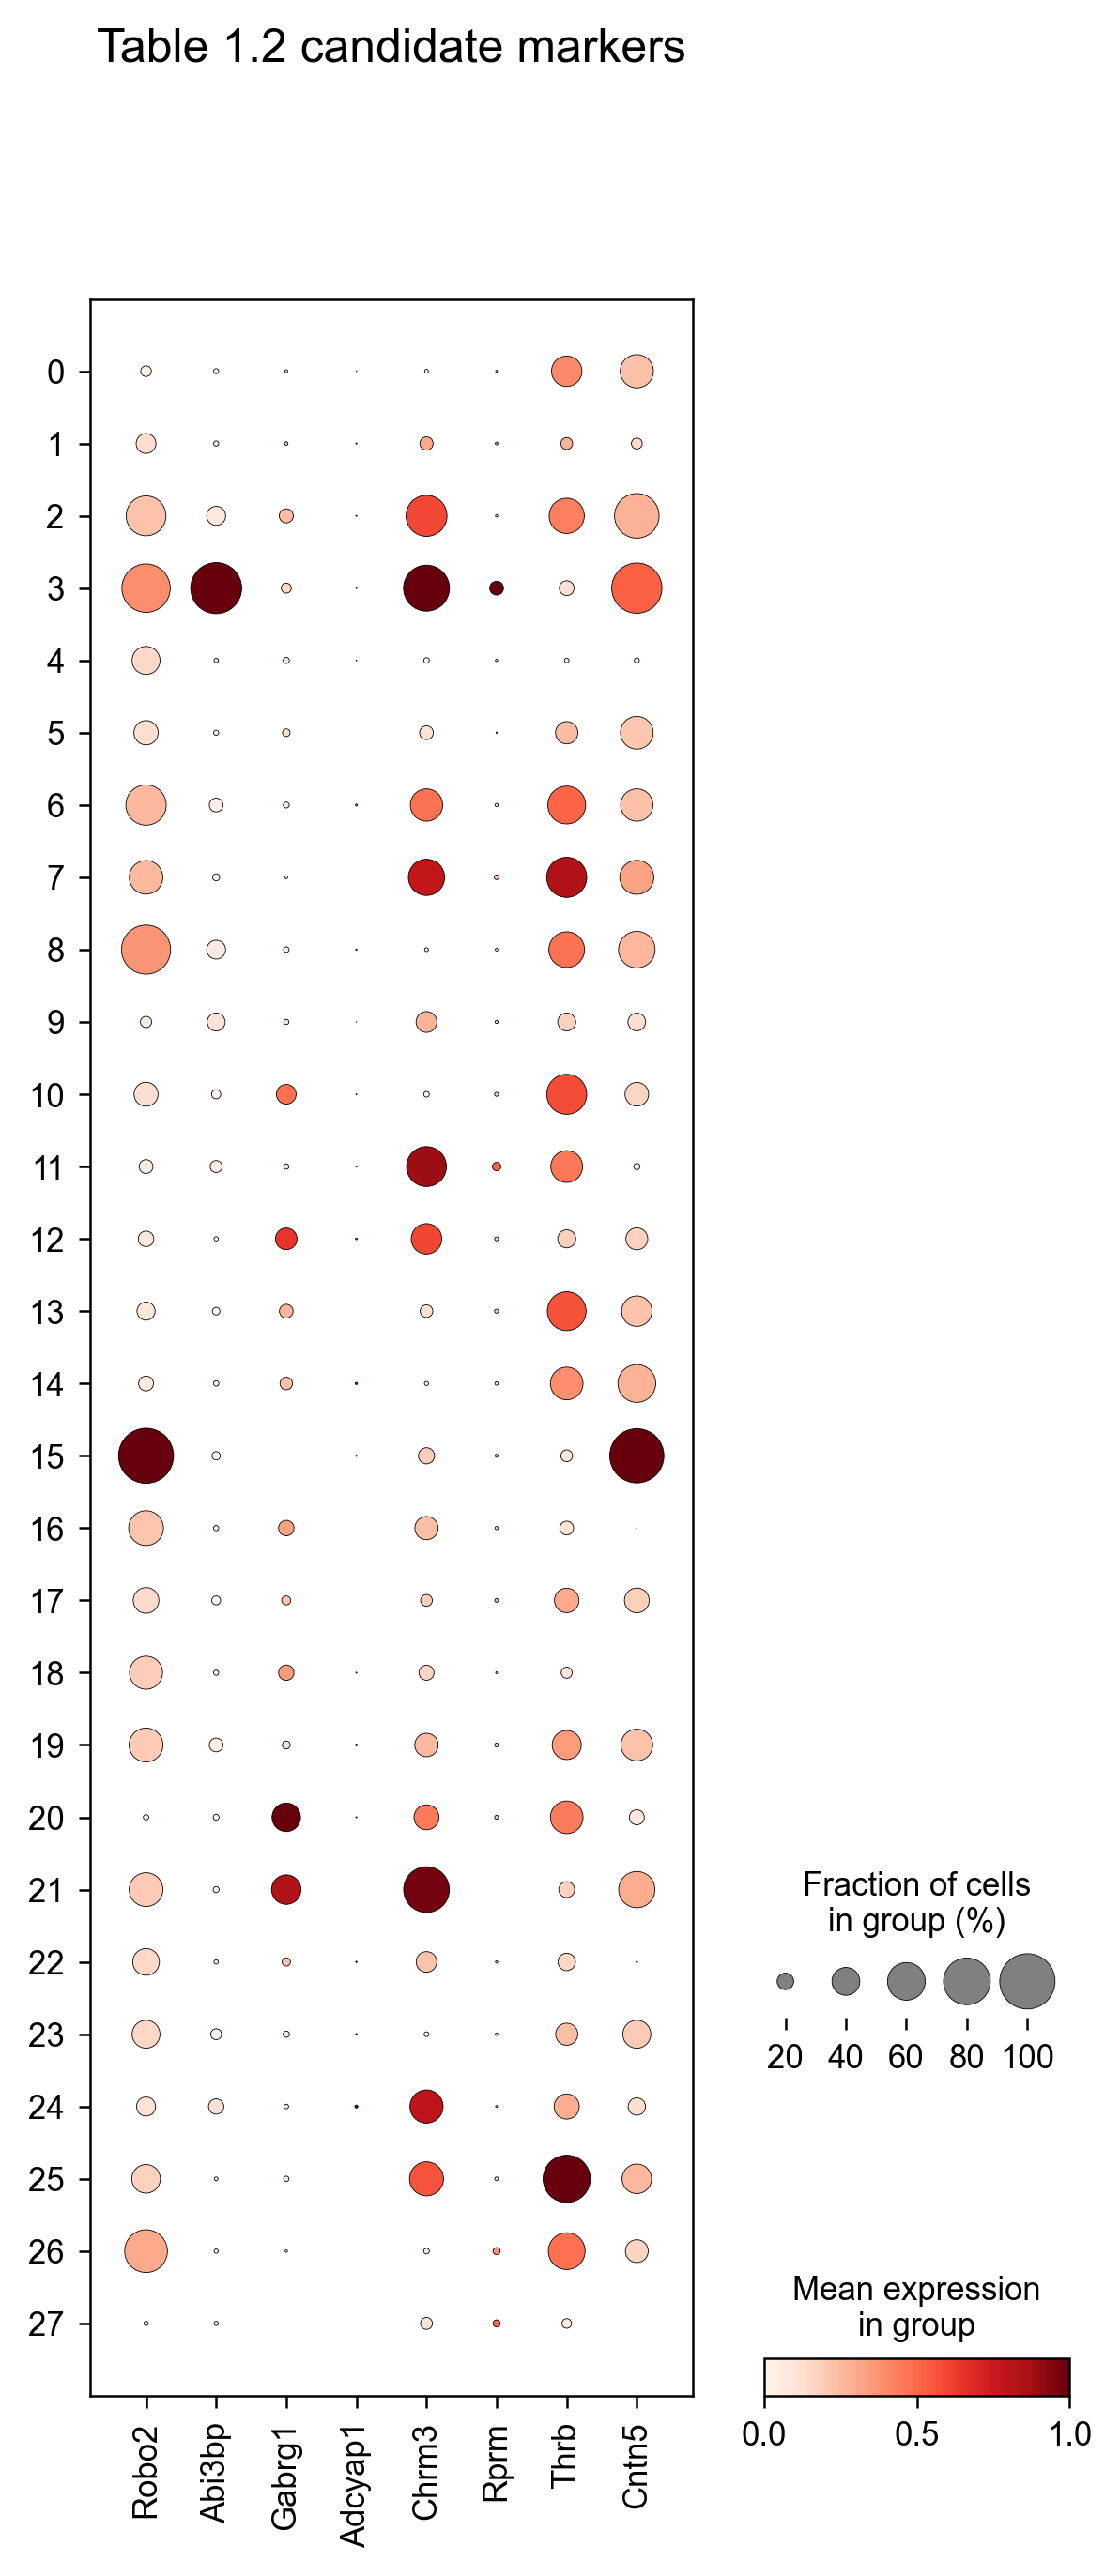

In [31]:
table_1_2_genes = ["Robo2", "Abi3bp", "Gabrg1", "Adcyap1", "Chrm3", "Rprm", "Thrb", "Cntn5"]
table_genes_present = [g for g in table_1_2_genes if g in adata.var_names]

if table_genes_present:
    sc.pl.dotplot(
        adata,
        table_genes_present,
        groupby="leiden",
        standard_scale="var",
        title="Table 1.2 candidate markers"
    )

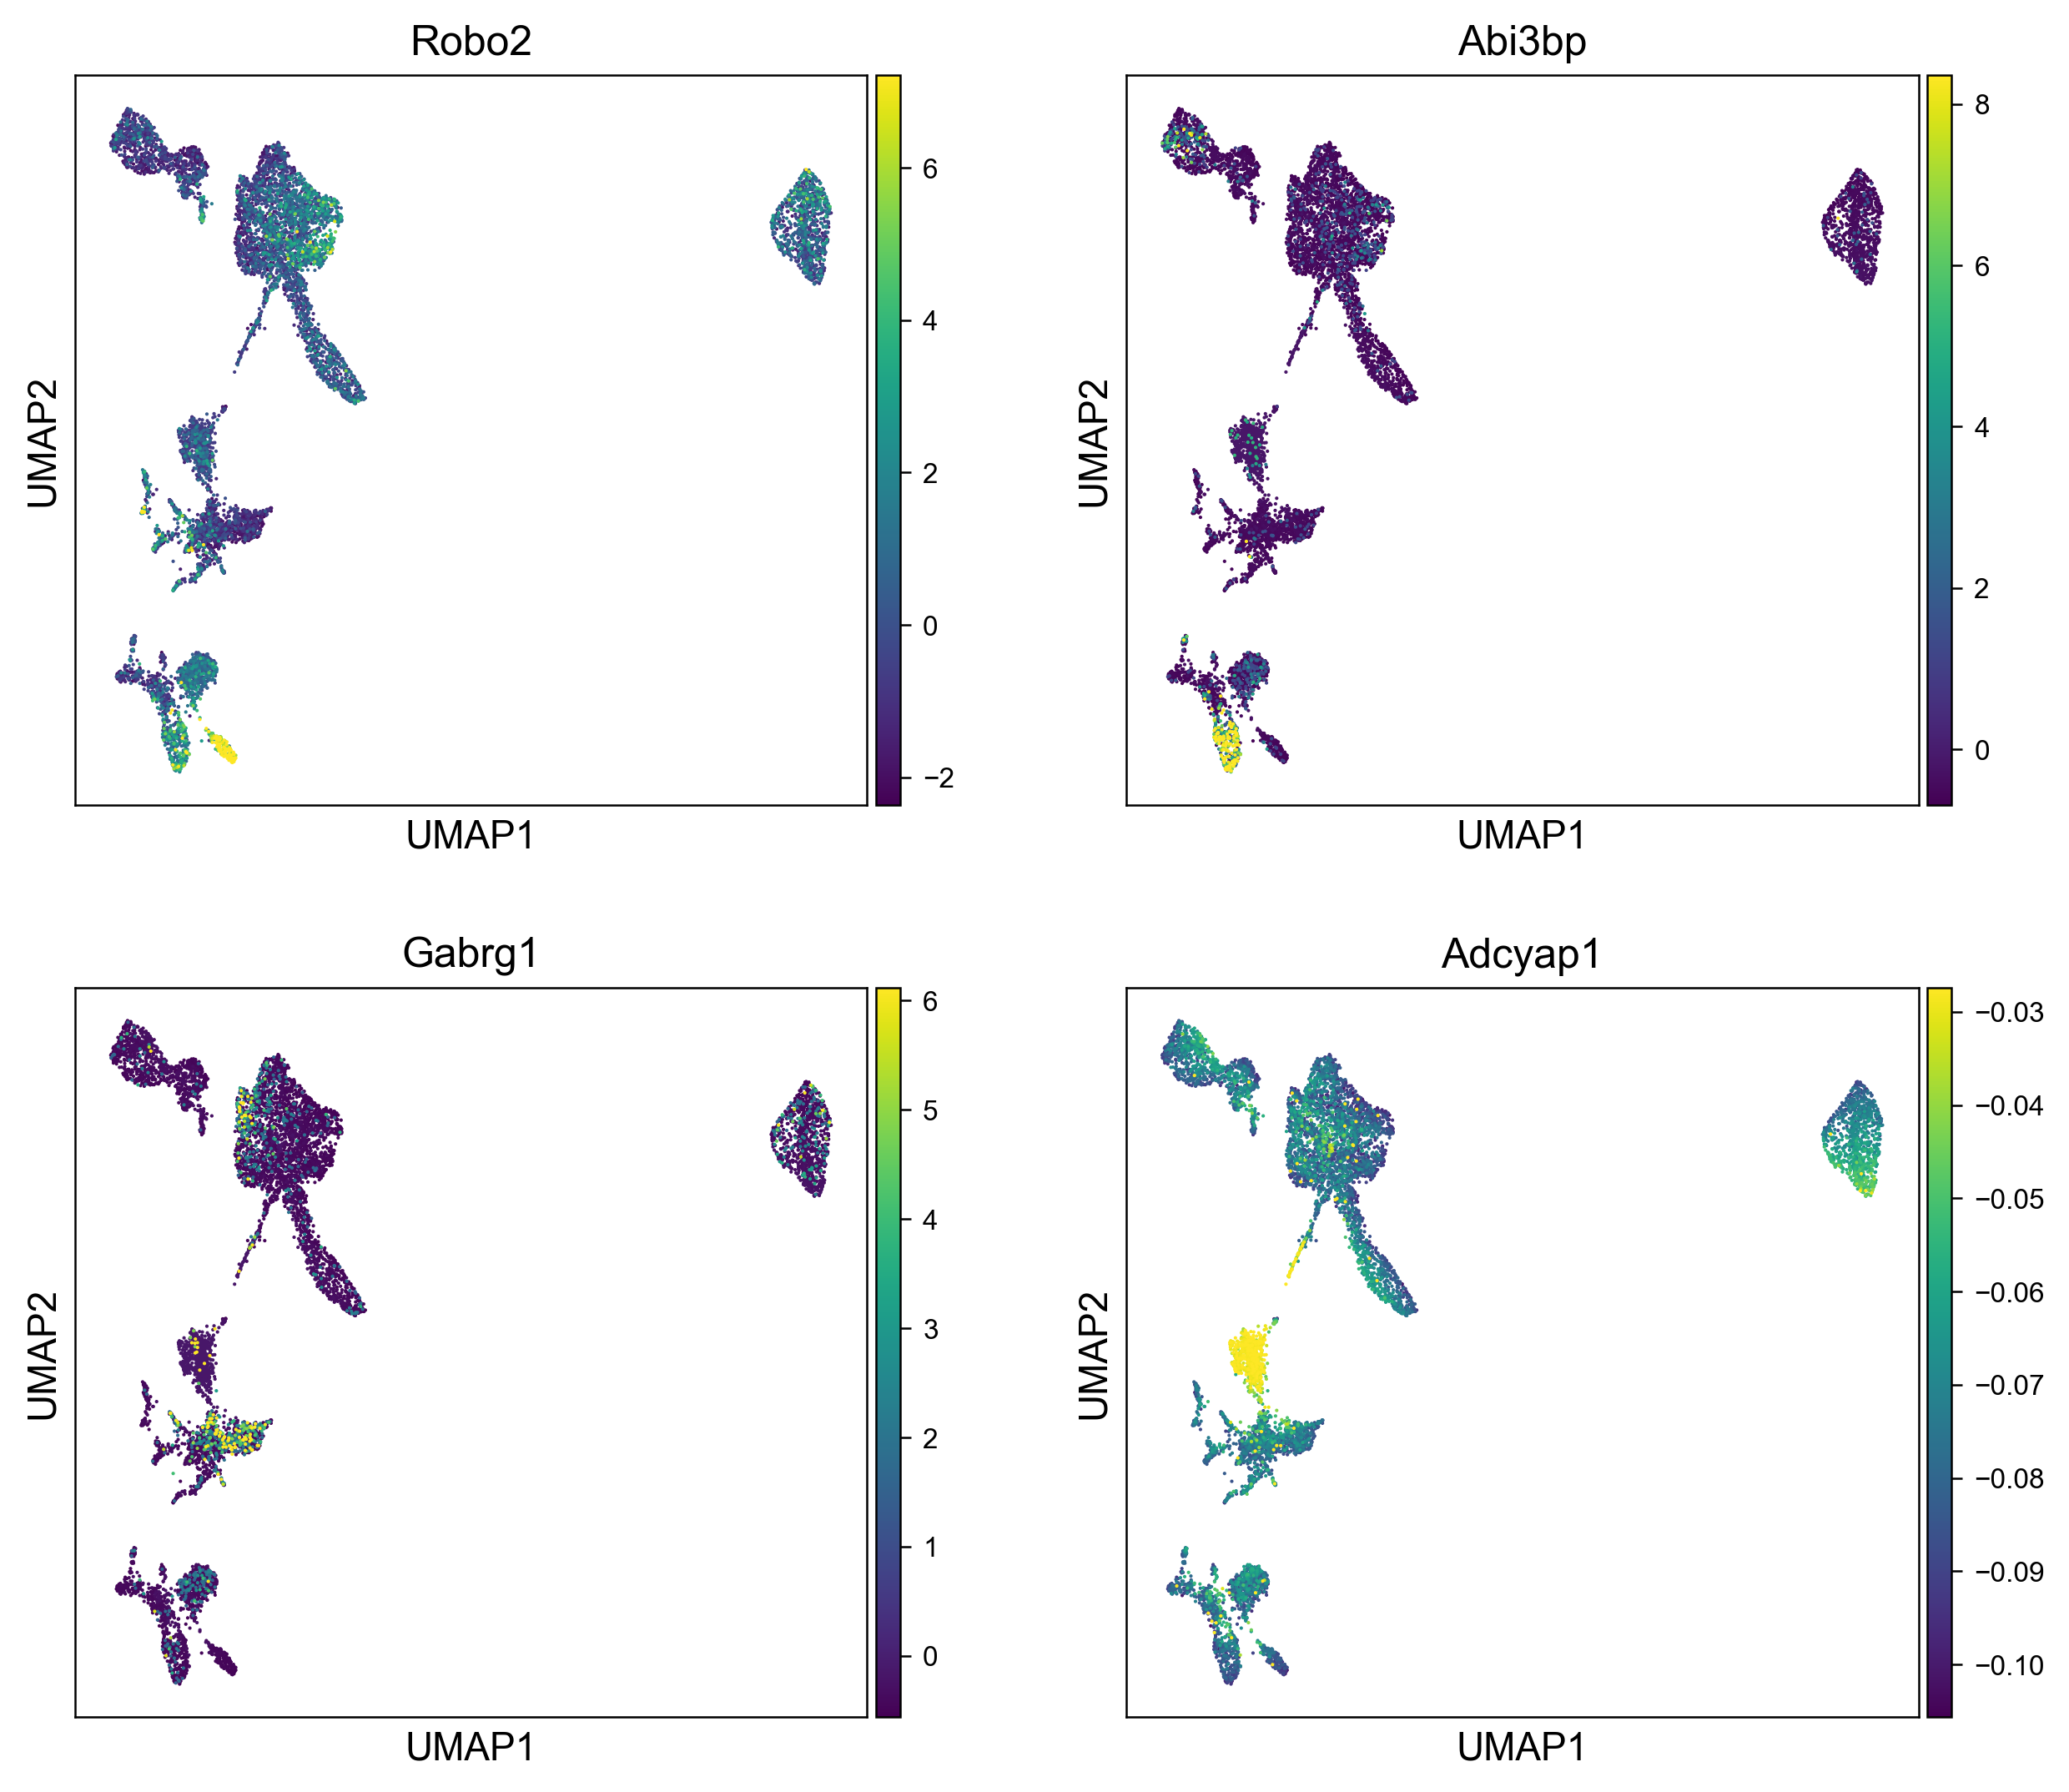

In [32]:
if table_genes_present:
    sc.pl.umap(adata, color=table_genes_present[:4], ncols=2, vmax="p99", size=4)

## Cluster Statistics

Cluster 1 stands out with only 540 mean genes, could be a low-complexity cell type
or leftover low-quality barcodes. Cluster 17 has the highest mito content at 1.7%,
which might mean some damaged nuclei ended up there.

In [33]:
cluster_stats = adata.obs.groupby("leiden", observed=True).agg(
    n_cells=("leiden", "size"),
    mean_genes=("n_genes_by_counts", "mean"),
    mean_counts=("total_counts", "mean"),
    mean_pct_mt=("pct_counts_mt", "mean")
).round(1)

cluster_stats["cell_class"] = cluster_stats.index.map(cluster_expr["cell_class"].to_dict())
cluster_stats = cluster_stats.sort_index(key=lambda x: x.astype(int))

flagged = []
for idx, row in cluster_stats.iterrows():
    if row["mean_genes"] < 800:
        flagged.append(f"Cluster {idx}: unusually low gene count ({row['mean_genes']:.0f})")
    if row["mean_pct_mt"] > 1.0:
        flagged.append(f"Cluster {idx}: elevated MT% ({row['mean_pct_mt']:.1f}%)")

print(cluster_stats.to_string())

if flagged:
    print("\nQC flags:")
    for f in flagged:
        print(f"  - {f}")

        n_cells  mean_genes  mean_counts  mean_pct_mt  cell_class
leiden                                                           
0           360      2024.0  4248.799805          0.1  Inhibitory
1           685       539.8   713.599976          0.1  Excitatory
2           546      1980.5  4256.700195          0.0  Inhibitory
3           274      2121.8  4614.000000          0.0  Excitatory
4           536      1945.4  3926.300049          0.1  Inhibitory
5           141      2082.4  3990.899902          0.1  Inhibitory
6           352      2095.9  4729.200195          0.0  Inhibitory
7           109      2117.3  4387.399902          0.2  Inhibitory
8           278      2230.6  5130.100098          0.0  Inhibitory
9           626      1947.2  3904.300049          0.1  Inhibitory
10          460      2070.3  4450.200195          0.0  Inhibitory
11          184      2149.9  4429.100098          0.1  Excitatory
12          584      2083.0  3962.000000          0.1  Inhibitory
13        

In [34]:
cluster_stats.to_csv(OUTPUT_DIR / "cluster_stats_TS.csv")
print(f"Saved cluster stats to {OUTPUT_DIR / 'cluster_stats_TS.csv'}")

Saved cluster stats to /Users/tisyasharma/Documents/Courses/AON_SnRNASeq_TS/output/cluster_stats_TS.csv


## Summary

**Final Results:** 8,885 cells, 28 clusters. 5 excitatory, 23 inhibitory. The candidate genes
show enrichment in the excitatory clusters, which makes sense since the contralateral
projection neurons we're after are glutamatergic.

Saved the h5ad for downstream use, so the MERFISH spatial analysis and Allen 10x DE
analysis pick up from here.

In [35]:
print("Analysis Summary")
print(f"Total cells: {adata.n_obs:,}")
print(f"Total genes: {adata.n_vars:,}")
print(f"Clusters: {adata.obs['leiden'].nunique()}")
print(f"Excitatory: {len(excitatory_clusters)}")
print(f"Inhibitory: {len(inhibitory_clusters)}")

Analysis Summary
Total cells: 8,885
Total genes: 21,586
Clusters: 28
Excitatory: 5
Inhibitory: 23


## Save Output

In [36]:
output_path = AON_DIR / "AON_TS.h5ad"
adata.write(output_path)
print(f"Saved to {output_path}")
print(f"Random seed used: {SEED} (for reproducibility)")

Saved to /Users/tisyasharma/Documents/Courses/AON_SnRNASeq_TS/data/aon_10x/AON_TS.h5ad
Random seed used: 42 (for reproducibility)
